# Financial Econometrics 2 - Project 2
## Matyáš Mattanelli & Jan Kubal

**Part A)**

*Old Assignment:*
Use same data as in Project 1, Estimate time varying OLS HAR. Find the kernel bandwidth minimizing out of smaple MSE, HAR horizons 1, 5, 22. 

---

## Project 2 - Instructions

**Details:** Students are encouraged to form a group of two for project 2 which will be assigned in three small parts during the semester. Evaluation of this project will be during the final exam, when students will present and discuss their results.

### Part A:
Construct the TV-HAR model with tvOLS (or with any other function). Find the kernel bandwidth minimizing the MSE for the out-of-sample forecast for horizons 1, 5, and 22.

### Part B:
Estimate time-varying volatility of stock price time series (or an index) using the Stochastic volatility model. You can take the specification from lecture notes (Lecture 9), or you can define your own. For this task, you can use R package "stochvol" or you can use any other tool for state space models.

Perform also an out-of-sample forecast (horizon 1, 5, 22) and compare the forecasting performance with a GARCH family model of your choice.

### Part C:
Construct the TV-HAR model using the QBLL estimator. Compare the out-of-sample forecast performance with models in **Part A** of Project 2.

### Final: Fusion of Project 1 and Project 2:
Compare the prediction performance of all TV models in this project with the best neural network model from Project 1.

## Environment preparation

In [1]:
#Activate the environment
import Pkg
Pkg.activate(".")
#Pkg.instantiate() #In case the environment is activated for the first time


  Activating project at `d:\My stuff\School\Master\3. semestr\Financial Econometrics II\Project 1`


In [2]:
#Load packages
import CSV
import DataFrames
import Plots
import StatsPlots
import Plots
import RCall
RCall.R"library(tvReg)"

#Load auxilliary functions
include("utils.jl")

┌ Warning: RCall.jl: Warning: package 'tvReg' was built under R version 4.2.2
│ Loading required package: Matrix
│ Warning: package 'Matrix' was built under R version 4.2.2
│ Funded by the Horizon 2020. Framework Programme of the European Union.
│ 
└ @ RCall C:\Users\matya\.julia\packages\RCall\Wyd74\src\io.jl:172


[> Loaded d:\My stuff\School\Master\3. semestr\Financial Econometrics II\Project 1\utils.jl


## Part A

In the first part we construct the time-varying HAR model (tvHAR) using the R package ``tvReg``, more specifically the ``tvLM`` function which is used to fit time-varying parameters linear models. For this modl, we find the kernel bandwidth minimizing the MSE for the out-of-sample forecast for horizons 1, 5, and 22.

The underlying asset is VanEck Oil Services ETF (OIH), which is an ETF aiming to reflect the overall market performance of US oil industry-related firms. Five years (January 2012 to December 2017) of 1-minute intraday prices were acquired from [kibot.com](http://www.kibot.com/free_historical_data.aspx).

We start with loading the data, computing the daily Realized Variance and creating the variables for HAR model (lagged versions of RV)

In [3]:
#Load data
data_OIH = CSV.read("OIH_adjusted_cut.csv", DataFrames.DataFrame; header=false);
data_OIH[1:5, :] #Take a peak at the data

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7
,String15,Time,Float64,Float64,Float64,Float64,Int64
1,01/03/2012,07:31:00,668.19,668.19,668.19,668.19,18
2,01/03/2012,08:00:00,648.82,648.82,648.82,648.82,35
3,01/03/2012,08:08:00,659.61,659.61,659.61,659.61,18
4,01/03/2012,09:01:00,662.71,662.71,662.71,662.71,159
5,01/03/2012,09:02:00,662.71,662.71,662.71,662.71,177


In [4]:
#Calculate RV 
target = get_RV_from_kibot(data_OIH, returns_log = false)

#Compute HAR regressors
predictors = HAR_regressors(target)
predictors = Float64.(predictors)

#Shift the target
target = target[23:end]
target = Float64.(target);

Now that the data is ready, we define a function estimating a single tvHAR model based on a single horizon and bandwidth. The function returns the MSE on the testing sample. Note that we set the parameter ``est`` of ``tvLM`` to "ll" in order to perform local linear estimation.

In [9]:
#Function for tvHAR estimation
function get_tvLM_MSE(horizon, bandwith; predictors = predictors, target = target, kernel = "Triweight")
    #Separate the testing and training sample
    predictors_train = predictors[1:end-horizon, :] 
    predictors_test = predictors[end-horizon+1:end, :]
    target_train = target[1:end-horizon]
    target_test = target[end-horizon+1:end]
    #Estimate the model and forecast
    RCall.R""" 
    tv_ols <- tvLM($target_train ~ $(predictors_train[:, 1]) + $(predictors_train[:, 2]) + $(predictors_train[:, 3]), bw = $bandwith , est = 'll', tkernel = $kernel)
    preds <- forecast(tv_ols, $predictors_test, n.ahead = $horizon)
    """
    #print(tv_ols$coefficients) prints out the coefficients
    preds = RCall.convert(Array{Float64}, RCall.R"preds") #Convert the predictions from R to Julia
    MSE = sum((preds .- target_test).^2)/length(preds) #Calculate the MSE
    return MSE
end

get_tvLM_MSE (generic function with 1 method)

In the next step we define a helper function that loops through multiple bandwiths, estimates a model for each and returns their out of sample MSE.

In [21]:
#Function for finding the optimal bandwidth for a specific horizon
function get_best_bw(min_bw, max_bw, step, horizon; predictors = predictors, target = target, kernel = "Triweight", verbose = false, plot_mses = true)
    bws = collect(range(min_bw, max_bw, step = step)) #Specify the range of bandwidths
    MSEs = zeros(length(bws)) #Empty array for the MSEs for each window
    for idx in 1:length(bws) #Loop through the bandwidths
        if verbose #Print info if required
            println("window $window_size out of $max_wind for horizon $horizon") 
        end
        MSEs[idx] = get_tvLM_MSE(horizon, bws[idx], predictors = predictors, target = target, kernel = kernel) #Get MSE for given iteration
    end
    if plot_mses #Plot the bandwidths agains the MSEs if required
        display(Plots.plot(bws, MSEs, legend = false, xlab = "Bandwidth", ylab = "MSE", title = "Horizon $horizon"))
    end
    return bws[argmin(MSEs)], minimum(MSEs) #Return the best bandwidth along with its MSE
end


get_best_bw (generic function with 1 method)

Now we can search through a range of bandwiths and find the one minimizing the out of sample MSE for each horizon.

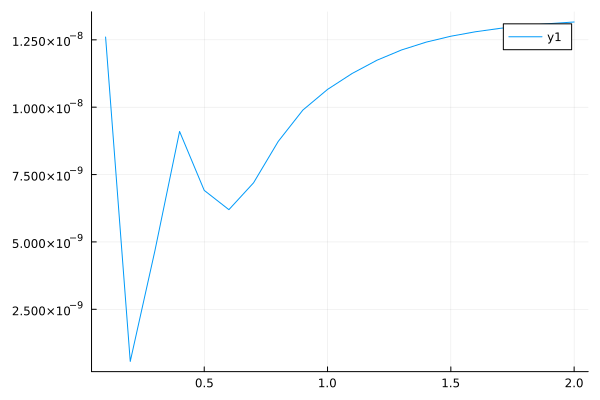

For horizon 1 found optimum window 0.2, MSE 5.650837574471458e-10


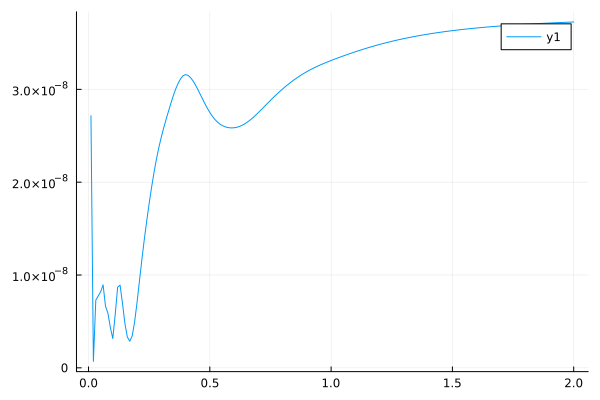

For horizon 5 found optimum window 0.02, MSE 6.905384921811106e-10


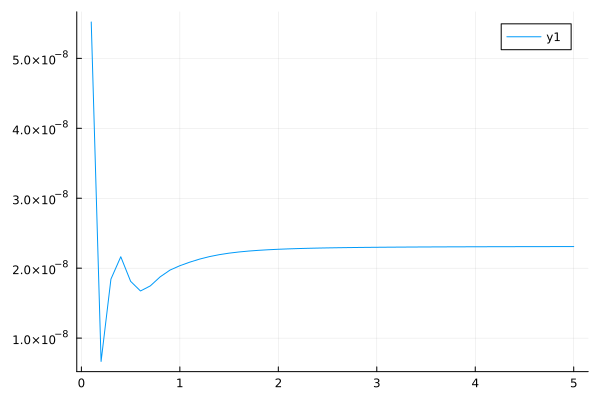

For horizon 22 found optimum window 0.2, MSE 6.668888245893575e-9


In [24]:
#runtime 5:50
#Horizon 1
optimum_hor_1 = get_best_bw(0.1, 2, 0.1, 1)
println("For horizon 1 found optimum window $(optimum_hor_1[1]), MSE $(optimum_hor_1[2])")
#Horizon 5
optimum_hor_5 = get_best_bw(0.01, 2, 0.01, 5)
println("For horizon 5 found optimum window $(optimum_hor_5[1]), MSE $(optimum_hor_5[2])")
#Horizon 22
optimum_hor_22 =  get_best_bw(0.1, 5, 0.1, 22)
println("For horizon 22 found optimum window $(optimum_hor_22[1]), MSE $(optimum_hor_22[2])")

As we can see, we find the minimum for all horizons. Horizons 1 and 22 share the same bandwidth of 0.2 while the optimal bandwidth for horizon 5 appears to be substantially smaller.

---
## Old code

In [286]:
#Calculating basic OLS parameters

test_size = 0
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size);
#WIP - lets first do simple OLS HAR on all the data
X_train_with_int = [ones((1, size(X_train)[2])); X_train] #Add ones for intercept estimation
inv(X_train_with_int * transpose(X_train_with_int)) * X_train_with_int * transpose(y_train) #Calculate the coefficients

4×1 Matrix{Float64}:
 9.82056424143176e-5
 0.03884726931711059
 0.17011491520317962
 0.4588606551734476

In [287]:
#now the function from Lectures - OLSestimatorconst
function OLSestimatorconst(y,x)
    x=[ones(size(x)[1]) x]
    return (transpose(x)*x) \ (transpose(x)*y)
end

OLSestimatorconst(target, predictors) #okk, we have working OLS HAR...now the Time variing part

4-element Vector{Float64}:
 9.820564033301494e-5
 0.03884727254180133
 0.17011492517697516
 0.45886064803361076

In [288]:
#now lets do the basic Rolling window OLS
window_size = 10
tv_parameters = zeros(size(predictors)[1]-window_size,size(predictors)[2] + 1) # plus one in the size for intercept

for i = 1:size(predictors)[1]-window_size #loop through one to end of data - window
    predictors_window = predictors[i:i+window_size-1, :] #always select subset for current window
    target_window = target[i:i+window_size-1]
    tv_parameters[i, :] = OLSestimatorconst(target_window, predictors_window) #make OLS estimate on it and save it
end
#size(tv_parameters)
#size(predictors)
#println(tv_parameters[1,:])
#println(tv_parameters[end,:])


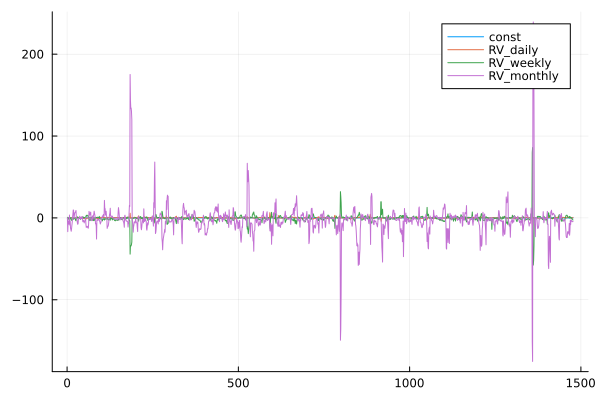

In [289]:
using Plots
plot([tv_parameters[:,1] tv_parameters[:,2] tv_parameters[:,3] tv_parameters[:,4]], label=["const" "RV_daily" "RV_weekly" "RV_monthly"])
#, tv_parameters[:,3], tv_parameters[:,4])

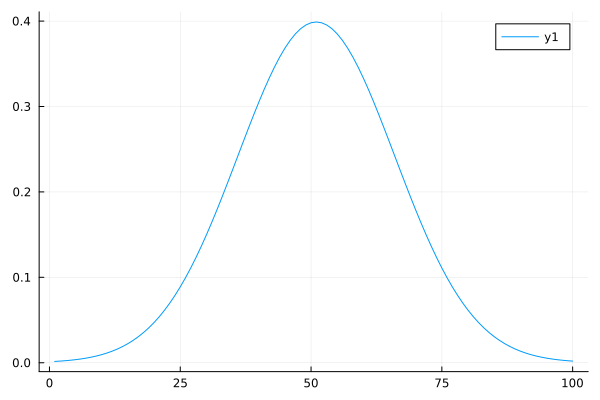

In [290]:
#Next TODO: make the poor mans version not so poor - add the kernel/smoothing
function Kernel(x,b)
    return (1/((sqrt(2*pi))))*exp(-0.5 *(x/b)^2)
end
#playing with Kernel
b=15
input = -50:49
kernel = zeros(length(1:100))
for i = 1:length(input)
    #kernel[i] = (1/((sqrt(2*pi))))*exp(-0.5 *(input[i]/b)^2)
    kernel[i] = Kernel(input[i], b)
end

plot(kernel)

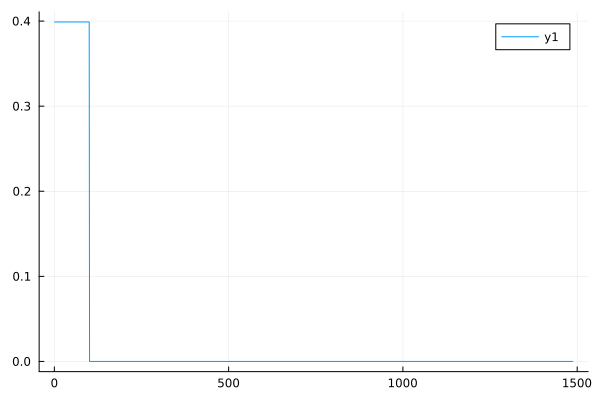

In [291]:
b=100
input = predictors[1:b, 1]
kernel = zeros(length(predictors[:, 1]))
for i = 1:length(input)
    #kernel[i] = (1/((sqrt(2*pi))))*exp(-0.5 *(input[i]/b)^2)
    kernel[i] = Kernel(input[i], b)
end

plot(predictors[1:b, 1]);
plot(kernel)

#I see, I will have to use the R package